# Проект 3 модуля. Возраст по цифровому следу

Цель проекта: Разработать модель машинного обучения, которая на основе анализа поведения пользователей в сети автоматически определяет их возрастную категорию для точного таргетинга рекламы.

In [ ]:
https://github.com/LadyTestCode/3module_project/

## Подготовка среды и библиотек

Импортируем все необходимые для работы тетрадки библиотеки:

In [1]:
%pip install phik -q
%pip install --upgrade category_encoders
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyClassifier
from phik import phik_matrix
from time import time
from sklearn.svm import SVC
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold, 
    cross_validate, 
    GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    MinMaxScaler, 
    TargetEncoder,
    FunctionTransformer)
from sklearn.pipeline import (Pipeline,  make_pipeline)
from sklearn.metrics import (
    precision_recall_curve, 
    auc, 
    brier_score_loss,
    make_scorer,
    log_loss, 
    average_precision_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

Установим настройки для отображения графиков и вывода датафреймов, также зададим случайную переменную RANDOM_SEED

In [4]:
pd.set_option('display.max_rows',60) # ограничиваем количество показываемых строк
pd.set_option('display.max_columns', None) # отображаем все столбцы
pd.set_option('display.width', 1000) # ширина экрана таблицы
pd.set_option('display.max_colwidth', None)
plt.figure(figsize=(8, 6)) # задаем размеры фигуры

RANDOM_SEED = 42 #Фиксируем случайную переменную

<Figure size 800x600 with 0 Axes>

## 2. Загрузка данных и предварительный анализ

Данные представлены в нескольких CSV-файлах. Они получены из разных источников, поэтому до моделирования они не объединены в единый датафрейм. Выпоним загрузку файлов, предусмотрев 2 варианта загрузки - с локального зранилищи и из облака.

In [5]:
# Локальная директорuя для хранения файлов
LOCAL_PATH = '/datasets/'

# Адрес облачного хранилища
STORAGE_URL = 'https://code.s3.yandex.net/datasets/'

# Название файлов
FILES = {
    'users': 'ds_s13_users.csv',
    'visits': 'ds_s13_visits.csv',
    'activity': 'ads_activity.csv',
     'surf_depth': 'surf_depth.csv',
     'primary_device': 'primary_device.csv',
     'cloud_usage': 'cloud_usage.csv',
}

dfs = dict()

# Попробовать загрузить файлы сначала из облака, затем из локальной директории
for name, filename in FILES.items():
    storage_path = STORAGE_URL + filename
    local_path = LOCAL_PATH + filename
    
    try:
        # Попытаться загрузить из облачного хранилища
        dfs[name] = pd.read_csv(storage_path)
        print(f'Файл "{filename}" успешно загружён из облачного хранилища.')
    except Exception as e:
        try:
            # Если не получилось из облака, попробуем из локальной директории
            dfs[name] = pd.read_csv(local_path)
            print(f'Файл "{filename}" успешно загружён из локальной директории.')
        except Exception as ex:
            print(f'Ошибка при загрузке файла "{filename}". Причина: {ex}')

# Назначим датафреймы соответствующим именам
df_users = dfs['users']
df_visits = dfs['visits']
df_activity = dfs['activity']
df_surf_depth = dfs['surf_depth']
df_primary_device = dfs['primary_device']
df_cloud_usage = dfs['cloud_usage']



Файл "ds_s13_users.csv" успешно загружён из облачного хранилища.
Файл "ds_s13_visits.csv" успешно загружён из облачного хранилища.
Файл "ads_activity.csv" успешно загружён из облачного хранилища.
Файл "surf_depth.csv" успешно загружён из облачного хранилища.
Файл "primary_device.csv" успешно загружён из облачного хранилища.
Файл "cloud_usage.csv" успешно загружён из облачного хранилища.


Сформируем список датафреймов для их группового анализа и удобной работе в цикле. Получим первую информацию о представленных данных.

In [6]:
dataframes = {"df_users": df_users, "df_visits": df_visits, "df_activity": df_activity, "df_surf_depth": df_surf_depth, "df_primary_device": df_primary_device, "df_cloud_usage": df_cloud_usage} 

In [7]:
# Проходим по всем датафреймам и выводим первые записи и info
for df_name, df in dataframes.items():
    print(f"\nДатафрейм {df_name}----------------")
    print(df.head())
    print(df.info())
    print('-'*35)


Датафрейм df_users----------------
                              user_id  age_category
0  f545-8c95aefe8d3e5548a689-a5b2fd39             4
1  cb48-5a0d6cde4d86ae10637e-c8ceb6ed             2
2  678b-614cd47d854b9d591db2-000b2e50             0
3  4ac0-dad169100b4a29b20818-b26ae7c5             4
4  f19b-9ac21ca973b41ecfa8c3-6a58191d             0
<class 'pandas.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       5913 non-null   str  
 1   age_category  5913 non-null   int64
dtypes: int64(1), str(1)
memory usage: 92.5 KB
None
-----------------------------------

Датафрейм df_visits----------------
         date daytime                            session_id                             user_id website_category
0  2025-11-01   вечер  066e4e02-8c1f-45eb-a50f-178659abe698  0010-5cf8f6b38a7b6c70a021-009dbcda      Category 17
1  2025-11-01   вечер  0bce1749-3376-439c-

Выведем колонки по типам для каждого датасета:

In [8]:
# Функция для вывода типов колонок
def show_column_types(df, df_name):
    print(f"Вывод типов колонок для датафрейма {df_name}:")
    
    # Колонки типа float64
    float_cols = df.select_dtypes(include=['float64']).columns.tolist()
    print("Колонки типа float64:", float_cols)
    
    # Колонки типа int64
    int_cols = df.select_dtypes(include=['int64']).columns.tolist()
    print("\nКолонки типа int64:", int_cols)
    
    # Колонки типа object
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    print("\nКолонки типа object:", obj_cols)
    print("-" * 50)

# Проходим по всем датафреймам и выводим типы колонок
for df_name, df in dataframes.items():
    show_column_types(df, df_name)

Вывод типов колонок для датафрейма df_users:
Колонки типа float64: []

Колонки типа int64: ['age_category']

Колонки типа object: ['user_id']
--------------------------------------------------
Вывод типов колонок для датафрейма df_visits:
Колонки типа float64: []

Колонки типа int64: []

Колонки типа object: ['date', 'daytime', 'session_id', 'user_id', 'website_category']
--------------------------------------------------
Вывод типов колонок для датафрейма df_activity:
Колонки типа float64: []

Колонки типа int64: []

Колонки типа object: ['user_id', 'ads_activity']
--------------------------------------------------
Вывод типов колонок для датафрейма df_surf_depth:
Колонки типа float64: []

Колонки типа int64: []

Колонки типа object: ['user_id', 'surf_depth']
--------------------------------------------------
Вывод типов колонок для датафрейма df_primary_device:
Колонки типа float64: []

Колонки типа int64: []

Колонки типа object: ['user_id', 'primary_device']
-----------------------

Проверим наличие пропусков в данных:

In [9]:
# Проходим по всем датафреймам и выводим количество пропусков в данных
for df_name, df in dataframes.items():
    print(f"\nКоличество пропусков в датафрейме {df_name} :")
    print(df.isnull().sum())


Количество пропусков в датафрейме df_users :
user_id         0
age_category    0
dtype: int64

Количество пропусков в датафрейме df_visits :
date                0
daytime             0
session_id          0
user_id             0
website_category    0
dtype: int64

Количество пропусков в датафрейме df_activity :
user_id         0
ads_activity    0
dtype: int64

Количество пропусков в датафрейме df_surf_depth :
user_id       0
surf_depth    0
dtype: int64

Количество пропусков в датафрейме df_primary_device :
user_id           0
primary_device    0
dtype: int64

Количество пропусков в датафрейме df_cloud_usage :
user_id        0
cloud_usage    0
dtype: int64


Пропусков в датасетах не обнаружено. Данные полные. ПОсмотрим ниже на базовые статистики датасетов:

In [10]:
# Проходим по всем датафреймам и выводим базовые статистики данных
for df_name, df in dataframes.items():
    print(f"\nБазовая статистика по датафрейму {df_name} :")
    print(df.describe())


Базовая статистика по датафрейму df_users :
       age_category
count   5913.000000
mean       2.441569
std        1.380322
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000

Базовая статистика по датафрейму df_visits :
              date  daytime                            session_id                             user_id website_category
count      1065745  1065745                               1065745                             1065745          1065745
unique          14        4                               1049995                                5826               20
top     2025-11-13     день  404c2438-7a91-4537-bd77-8ea6a14b34ec  5ff2-0a5aa967e353041283b9-ff7929cc      Category 03
freq         76599   389052                                     2                                 853            70260

Базовая статистика по датафрейму df_activity :
                                   user_id ads_activity
count                         

Выявим явные дубликаты в записях и удалим их:

In [11]:
for df_name, df in dataframes.items():
    print(f"\nПоиск явных дубликатов по датафрейму {df_name} :")
    duplicates = df[df.duplicated()]  
    if duplicates.empty:
        print("Явных дубликатов не найдено.")
    else:
        print("Строки-дубликаты (будут удалены):")
        print(duplicates)    
    # Удаление явных дубликатов
    df_cleaned = df.drop_duplicates()
print("Строки-дубликаты были удалены")


Поиск явных дубликатов по датафрейму df_users :
Строки-дубликаты (будут удалены):
                                 user_id  age_category
326   3bdd-4131152c20bbe4a56bdd-f6474b41             4
355   3360-1ea0274d97bc1b80026b-36b1934d             4
503   9bd6-b1663d3dd9859692bd1d-1fdc22cd             4
739   8705-51a37e7638d29f495b21-8cf783d8             3
754   ea64-ae0d1ec99654768bd6f7-a40d9a81             2
...                                  ...           ...
5709  48c4-88e07854a9125ee372de-bef57968             3
5784  ec4b-649d01a7343855b471db-857fe97f             4
5811  81b3-d3a8a19cfff77a75c571-a81355fc             2
5868  c1c6-7ce02c0dd580afef460d-45dbc7a2             0
5892  a196-495d4dacf979da2d37cf-888a004c             4

[87 rows x 2 columns]

Поиск явных дубликатов по датафрейму df_visits :
Строки-дубликаты (будут удалены):
               date daytime                            session_id                             user_id website_category
18       2025-11-01   вечер  40

## Исследовательский анализ данных

Построим гистограммы распределения признаков для каждого датафрейма кроме лога посещений (он слишком большой и кроме того ввиду особенностей данных построение не будет информативным.)


Анализ и визуализация признаков для датафрейма df_users:



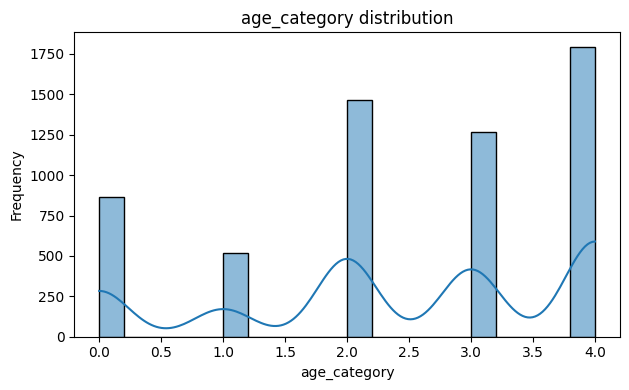


Анализ и визуализация признаков для датафрейма df_activity:



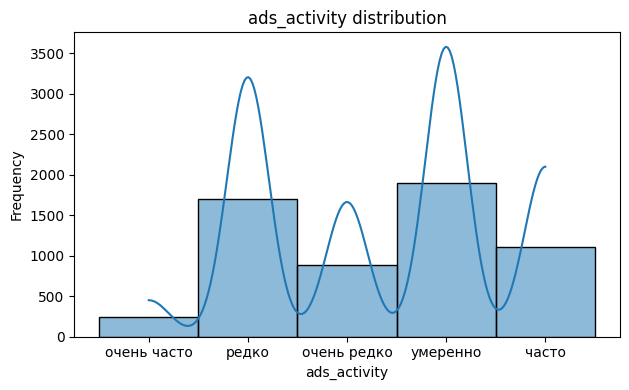


Анализ и визуализация признаков для датафрейма df_surf_depth:



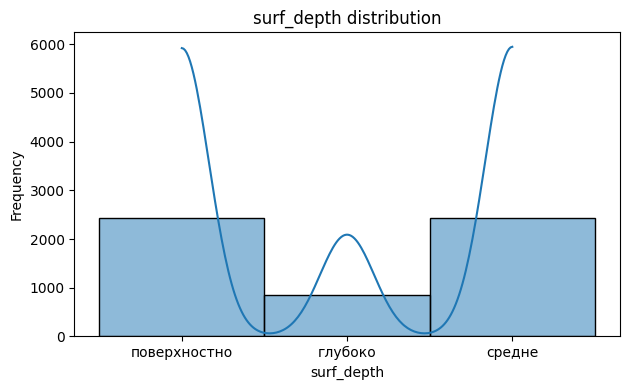


Анализ и визуализация признаков для датафрейма df_primary_device:



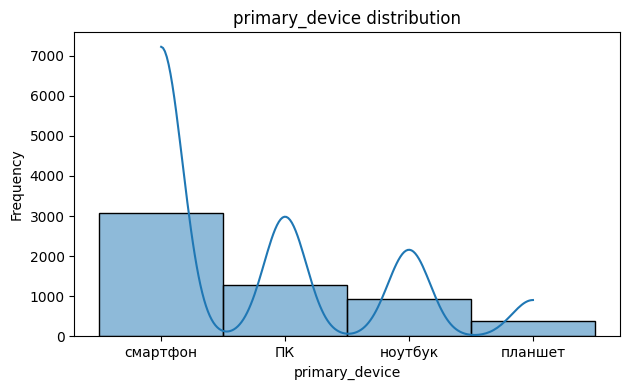


Анализ и визуализация признаков для датафрейма df_cloud_usage:



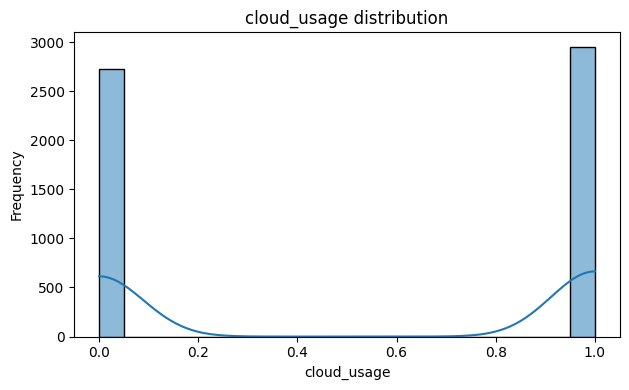

In [12]:
    # Построение гистограмм распределения признаков для каждого датафрейма кроме лога посещений
for df_name, df in dataframes.items():
    if df_name !='df_visits':
        print(f"\nАнализ и визуализация признаков для датафрейма {df_name}:\n")
        
        # Количество столбцов для grid-графиков
        num_cols = len(df.columns)
        rows = (num_cols + 1) // 2  # Округлим вверх
        cols = 2 if num_cols > 1 else 1
        
        # Рисуем гистограммы
        plt.figure(figsize=(12, 4*rows))  # Настройка размера окна графика
        for i, col in enumerate(df.columns):
            if col !='user_id':
                plt.subplot(rows, cols, i+1)
                sns.histplot(df[col], bins=20, kde=True)
                plt.title(f"{col} distribution")
                plt.xlabel(col)
                plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

В принципе никаких аномалий в данных не видно, распределение признаков соответствует их значению.

На данном этапе уже можно объединить датафреймы в один, без датафрейма с логом посещений. Его нужно поисследовать отдельно,  в том числе для создания новых признаков и аггрегирования данных.

In [13]:
merged_df = df_users.merge(df_activity, on='user_id', how='left').merge(df_surf_depth, on='user_id', how='left').merge(df_primary_device, on='user_id', how='left').merge(df_cloud_usage, on='user_id', how='left')

Выведем общую информацию по объединенному датафрейму.

In [14]:
print(merged_df.info())

<class 'pandas.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         6146 non-null   str   
 1   age_category    6146 non-null   int64 
 2   ads_activity    5908 non-null   str   
 3   surf_depth      6029 non-null   str   
 4   primary_device  5982 non-null   str   
 5   cloud_usage     5991 non-null   object
dtypes: int64(1), object(1), str(4)
memory usage: 288.2+ KB
None


Датафрейм с логом мы пока не присоединяли, потому что данные из него требуют отдельного анализа, и на одного пользователя приходится много строк. Соответственно, нужна агрегация данных. Попробуем собрать из этого лога отдельный профиль пользователя с параметрами, который потом можно будет присоединить к уже объединенному датафрейму.

*Что можно выбрать из лога:*  
Базовые метрики активности:  
-total_sessions - общее количество сессий  
-total_days - количество дней с активностью  
-total_actions - общее количество действий   
-avg_sessions_per_day - среднее количество сессий в день  

Активность по времени суток:  
-daytime_утро_ratio, daytime_день_ratio, daytime_вечер_ratio, daytime_ночь_ratio - доли активности в разное время    
-most_active_daytime - наиболее активное время суток  

Предпочтения по категориям сайтов:  
-Доли посещений для топ-10 категорий  
-other_categories_ratio - доля остальных категорий  

Дополнительные метрики:  
-avg_actions_per_session - среднее количество действий за сессию  
-activity_regularity - регулярность использования (доля дней с активностью в общем периоде)  

Типологизация пользователей:  
-user_activity_type - тип по частоте активности (very_active, active, moderate, rare)  
-user_diversity_type - тип по разнообразию категорий (diverse, moderate, focused)

In [15]:
def create_user_portraits(df_visits):
    # 1. Базовые признаки по сессиям
    # Исправляем: используем словарь с кортежами (название, функция)
    user_features = df_visits.groupby('user_id').agg(
        total_sessions=('session_id', 'nunique'),
        total_days=('date', 'nunique'),
        first_visit=('date', 'min'),
        last_visit=('date', 'max'),
        total_actions=('website_category', 'count')
    ).reset_index()
    
    # Вычисляем среднее количество сессий в день
    user_features['avg_sessions_per_day'] = (user_features['total_sessions'] / user_features['total_days']).round(4)
    
    # Вычисляем общую продолжительность активности в днях
    user_features['first_visit'] = pd.to_datetime(user_features['first_visit'])
    user_features['last_visit'] = pd.to_datetime(user_features['last_visit'])
    user_features['activity_days_span'] = (user_features['last_visit'] - user_features['first_visit']).dt.days + 1
    user_features['activity_days_span'] = user_features['activity_days_span'].clip(lower=1)
    
    # 2. Активность по времени суток (доли)
    # Исправляем: создаем кросс-таблицу правильно
    daytime_counts = pd.crosstab(df_visits['user_id'], df_visits['daytime'])
    daytime_stats = daytime_counts.div(daytime_counts.sum(axis=1), axis=0).round(4)
    daytime_stats = daytime_stats.reset_index()
    
    # Переименовываем колонки
    daytime_stats.columns = ['user_id'] + [f'daytime_{col}_ratio' for col in daytime_stats.columns if col != 'user_id']
    
    # Наиболее активное время суток
    daytime_max = daytime_counts.idxmax(axis=1).reset_index()
    daytime_max.columns = ['user_id', 'most_active_daytime']
    
    # 3. Активность по категориям сайтов (доли)
    # Топ-10 категорий
    top_categories = df_visits['website_category'].value_counts().head(10).index
    
    # Создаем кросс-таблицу для категорий
    category_counts = pd.crosstab(df_visits['user_id'], df_visits['website_category'])
    category_stats = category_counts.div(category_counts.sum(axis=1), axis=0).round(4)
    
    # Оставляем только топ-категории
    category_cols = [col for col in category_stats.columns if col in top_categories]
    category_stats_filtered = category_stats[category_cols].copy()
    category_stats_filtered['other_categories_ratio'] = 1 - category_stats_filtered.sum(axis=1)
    category_stats_filtered = category_stats_filtered.reset_index()
    
    # Переименовываем колонки категорий
    rename_dict = {col: f'cat_{col}_ratio' for col in category_cols}
    rename_dict['other_categories_ratio'] = 'other_categories_ratio'
    category_stats_filtered = category_stats_filtered.rename(columns=rename_dict)
    
    # 4. Дополнительные метрики активности
    # Интенсивность использования
    actions_per_session = df_visits.groupby('user_id').agg(
        total_actions=('session_id', 'count'),
        total_sessions=('session_id', 'nunique')
    ).reset_index()
    actions_per_session['avg_actions_per_session'] = (
        actions_per_session['total_actions'] / actions_per_session['total_sessions']
    ).round(4)
    actions_per_session = actions_per_session[['user_id', 'avg_actions_per_session']]
    
    # Регулярность использования
    regularity = user_features[['user_id', 'total_days', 'activity_days_span']].copy()
    regularity['activity_regularity'] = (regularity['total_days'] / regularity['activity_days_span']).round(4)
    
    # 5. Объединяем все признаки
    # Начинаем с базовых признаков (убираем лишние колонки)
    user_portrait = user_features[['user_id', 'total_sessions', 'total_days', 'total_actions', 
                                   'avg_sessions_per_day', 'activity_days_span']].copy()
    
    # Добавляем признаки по времени суток
    user_portrait = user_portrait.merge(daytime_stats, on='user_id', how='left')
    user_portrait = user_portrait.merge(daytime_max, on='user_id', how='left')
    
    # Добавляем признаки по категориям
    user_portrait = user_portrait.merge(category_stats_filtered, on='user_id', how='left')
    
    # Добавляем дополнительные метрики
    user_portrait = user_portrait.merge(actions_per_session, on='user_id', how='left')
    user_portrait = user_portrait.merge(regularity[['user_id', 'activity_regularity']], on='user_id', how='left')
    
    # Заполняем пропуски
    user_portrait = user_portrait.fillna(0)
    
    # 6. Создаем категориальные признаки
    def get_user_type(row):
        if row['avg_sessions_per_day'] >= 3:
            return 'very_active'
        elif row['avg_sessions_per_day'] >= 1:
            return 'active'
        elif row['avg_sessions_per_day'] >= 0.3:
            return 'moderate'
        else:
            return 'rare'
    
    user_portrait['user_activity_type'] = user_portrait.apply(get_user_type, axis=1)
    
    # Тип пользователя по разнообразию категорий
    cat_ratio_cols = [col for col in user_portrait.columns if col.startswith('cat_') and col.endswith('_ratio')]
    user_portrait['category_diversity'] = (user_portrait[cat_ratio_cols] > 0.05).sum(axis=1)
    
    def get_diversity_type(row):
        if row['category_diversity'] >= 5:
            return 'diverse'
        elif row['category_diversity'] >= 3:
            return 'moderate'
        else:
            return 'focused'
    
    user_portrait['user_diversity_type'] = user_portrait.apply(get_diversity_type, axis=1)
    
    return user_portrait

# Применяем функцию
user_portrait_df = create_user_portraits(df_visits)

# Проверяем результат
print("Размерность датафрейма:", user_portrait_df.shape)
print("\nКолонки:")
print(user_portrait_df.columns.tolist())
print("\nПервые строки:")
print(user_portrait_df.head())
print("\nОбщая информация:")
print(user_portrait_df.info())

Размерность датафрейма: (5826, 27)

Колонки:
['user_id', 'total_sessions', 'total_days', 'total_actions', 'avg_sessions_per_day', 'activity_days_span', 'daytime_вечер_ratio', 'daytime_день_ratio', 'daytime_ночь_ratio', 'daytime_утро_ratio', 'most_active_daytime', 'cat_Category 01_ratio', 'cat_Category 03_ratio', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', 'avg_actions_per_session', 'activity_regularity', 'user_activity_type', 'category_diversity', 'user_diversity_type']

Первые строки:
                              user_id  total_sessions  total_days  total_actions  avg_sessions_per_day  activity_days_span  daytime_вечер_ratio  daytime_день_ratio  daytime_ночь_ratio  daytime_утро_ratio most_active_daytime  cat_Category 01_ratio  cat_Category 03_ratio  cat_Category 05_ratio  cat_Category 06_ratio  cat_Catego

Построим гистограммы распределения по новому датафрейму с аггрегированными признаками:

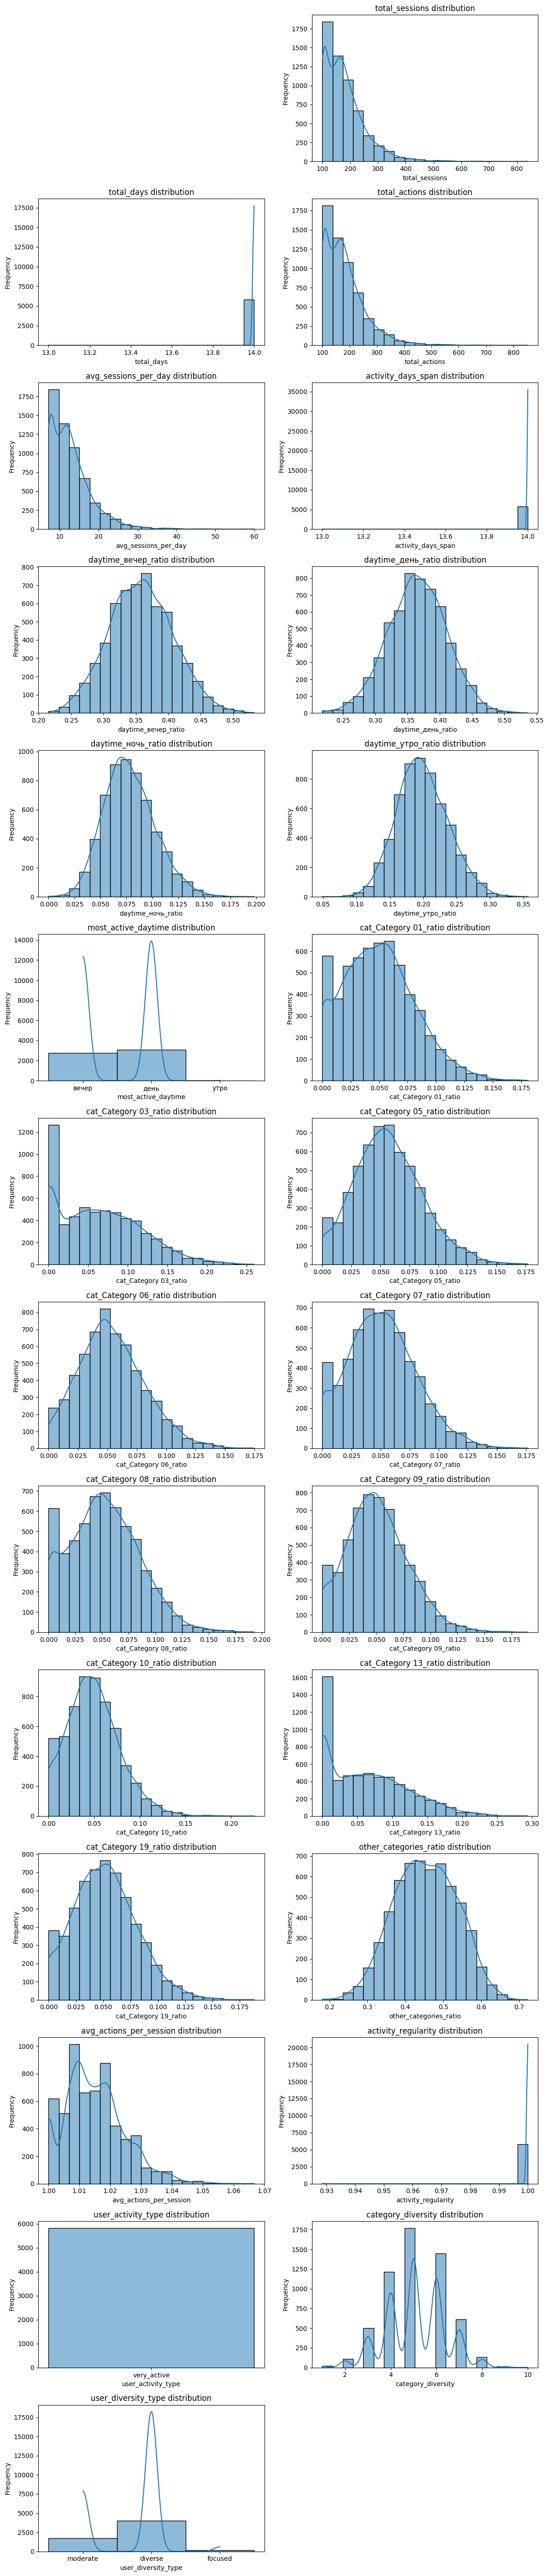

In [16]:
# Количество столбцов для grid-графиков
num_cols = len(user_portrait_df.columns)
rows = (num_cols+1) // 2 
cols = 2 if num_cols > 1 else 1
        
# Рисуем гистограммы
plt.figure(figsize=(12, 4*rows))  # Настройка размера окна графика
for i, col in enumerate(user_portrait_df.columns):
    if col !='user_id':
        plt.subplot(rows, cols, i+1)
        sns.histplot(user_portrait_df[col], bins=20, kde=True)
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        
plt.tight_layout()
plt.show()

In [17]:
print(user_portrait_df.describe().T)

                          count        mean        std       min         25%       50%         75%       max
total_sessions           5826.0  180.225712  75.186802  100.0000  124.000000  167.0000  213.000000  839.0000
total_days               5826.0   13.998627   0.037034   13.0000   14.000000   14.0000   14.000000   14.0000
total_actions            5826.0  182.929111  76.390669  100.0000  126.000000  169.0000  217.000000  853.0000
avg_sessions_per_day     5826.0   12.874051   5.369729    7.1429    8.857100   11.9286   15.214300   59.9286
activity_days_span       5826.0   13.999657   0.018526   13.0000   14.000000   14.0000   14.000000   14.0000
daytime_вечер_ratio      5826.0    0.358152   0.049283    0.2155    0.323700    0.3577    0.392000    0.5325
daytime_день_ratio       5826.0    0.364977   0.045458    0.2178    0.335100    0.3653    0.395500    0.5364
daytime_ночь_ratio       5826.0    0.078123   0.024757    0.0000    0.060800    0.0763    0.093600    0.1980
daytime_утро_ratio 

По гистограмме распределения можно увидеть, что у колонки user_activity_type всего одно значение - все пользователи очень активные, в дальнейшем эту колонку можно будет исключить из моделирования, остальные колонки имеют различные рапсределения, но сильных выбросов не заметно. Нужно будет провести нормализацию признаков.

In [18]:
print(user_portrait_df['user_activity_type'].describe())

count            5826
unique              1
top       very_active
freq             5826
Name: user_activity_type, dtype: object


Объединим датасеты в один и удалим колонки user_id и user_activity_type:

In [19]:
union_merged_df = merged_df.merge(user_portrait_df, on='user_id', how='left')

In [20]:
# Список колонок для удаления
cols_to_drop = [ 'user_id', 'user_activity_type']
# Удаление указанных колонок из датафрейма
union_merged_df.drop(columns=cols_to_drop, inplace=True)

## 4. Анализ целевой переменной и корреляций признаков с целевой переменной

Проанализируем распределение целевой переменной. Определим, есть ли дисбаланс классов для последующего выбора метрик.
Целевая переменная содержится в колонке age_category — категоральный признак, указывающий, к какой возрастной категории относится пользователь.

Процентное соотношение:
age_category
4    30.572730
2    24.910511
3    21.265864
0    14.529775
1     8.721119
Name: count, dtype: float64


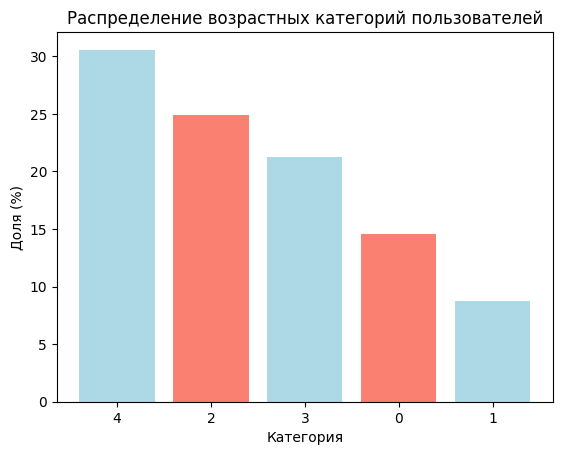

In [21]:
# Подсчетаем количество каждого значения в колонке 'age_category'
counts = union_merged_df['age_category'].value_counts()
percentages = counts / len(union_merged_df) * 100

# Отображение результатов
print("Процентное соотношение:")
print(percentages)

# Построим столбчатую диаграмму
plt.bar(['4', '2','3', '0','1'], percentages.values, color=['lightblue', 'salmon'])
plt.title('Распределение возрастных категорий пользователей')
plt.xlabel('Категория')
plt.ylabel('Доля (%)')
plt.show()

Как мы видим, классы пользователей распределены в целом равномерно (нет сильных скачков между колонками), есть возраст, в котором меньше пользователей, есть возрастная категория, к которой относится больше всего пользователей - это категоря 4: 56+ лет, но в целом картина довольно правильная. 

Корреляционная матрица с коэффициентом phi_k для age_category
interval columns not set, guessing: ['age_category', 'total_sessions', 'total_days', 'total_actions', 'avg_sessions_per_day', 'activity_days_span', 'daytime_вечер_ratio', 'daytime_день_ratio', 'daytime_ночь_ratio', 'daytime_утро_ratio', 'cat_Category 01_ratio', 'cat_Category 03_ratio', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', 'avg_actions_per_session', 'activity_regularity', 'category_diversity']
Корреляции признаков с age_category (отсортировано по убыванию):
                         age_category
daytime_вечер_ratio          0.681435
cat_Category 13_ratio        0.597723
daytime_утро_ratio           0.579185
daytime_день_ratio           0.569743
cat_Category 09_ratio        0.529721
daytime_ночь_ratio           0.527587
cat_Category 07_ratio 

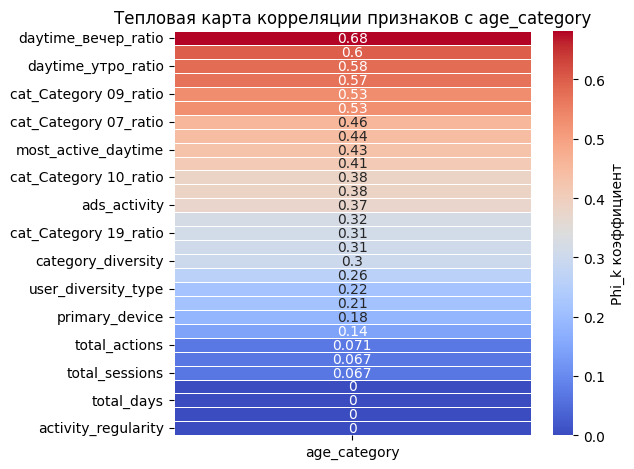

In [22]:
print('Корреляционная матрица с коэффициентом phi_k для age_category')
correlation_matrix = union_merged_df.phik_matrix()
# Извлекаем только корреляцию признаков с age_category (исключая саму age_category)
correlation_matrix_click = correlation_matrix.loc[correlation_matrix.index != 'age_category'][['age_category']]
# Сортируем по убыванию абсолютных значений корреляции
correlation_matrix_click_sorted = correlation_matrix_click.reindex(
    correlation_matrix_click['age_category'].abs().sort_values(ascending=False).index
)
print("Корреляции признаков с age_category (отсортировано по убыванию):")
print(correlation_matrix_click_sorted)
# Строим тепловую карту
sns.heatmap(correlation_matrix_click_sorted, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Phi_k коэффициент'})
plt.title('Тепловая карта корреляции признаков с age_category')
plt.tight_layout()  # Добавил для автоматической подгонки макета
plt.show()

По матрице корреляции мы видим, что у признаков есть корреляция с целевой переменной: при этом у признака daytime_вечер_ratio она самая большая. Все эти признаки оставим для моделирования. 
Есть признаки, у которых корреляция с целевой переменной =0, это признаки:  
- activity_days_span     
- total_days                  
- avg_actions_per_session      
- activity_regularity  
Это признаки, посчитанные по датафрейму с логами, возможно их тоже можно будет удалить.    

Попробуем найти признаки, которые сильно скоррелированы между собой - они могут быть тоже удалены из модели:

In [23]:
strong_correlations = []
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)): # Избегаем повторений и диагональ
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            corr_value = round(abs(correlation_matrix.iloc[i, j]), 3)
            strong_correlations.append((feature_1, feature_2, corr_value))

if not strong_correlations:
    print("Нет пар признаков с сильной корреляцией.")
else:
    result_df = pd.DataFrame(strong_correlations, columns=['Признак 1', 'Признак 2', 'Корреляция'])
    print(result_df.sort_values(by='Корреляция', ascending=False))  # Сортируем по убыванию силы корреляции

            Признак 1             Признак 2  Корреляция
0      total_sessions         total_actions        1.00
1      total_sessions  avg_sessions_per_day        1.00
3       total_actions  avg_sessions_per_day        1.00
4  category_diversity   user_diversity_type        1.00
2          total_days   activity_regularity        0.96


Можно удалить некоторые сильно коррелируемые колонки и колонки не имеющие корреляции с целевой переменной:

In [24]:
# Список колонок для удаления - больше колонок удалять не будем на этом этапе, позволим модели самой отобрать признаки.
cols_to_drop = [ 'activity_regularity', 'total_sessions', 'total_days', 'avg_actions_per_session']
# Удаление указанных колонок из датафрейма
for col in cols_to_drop:
    if col in union_merged_df.columns:
        union_merged_df.drop(col, axis=1, inplace=True)
    else:
        print(f'Колонка "{col}" отсутствует в датафрейме.')

In [25]:
# Вывод списка всех колонок датафрейма
print("Список колонок в датафрейме union_merged_df:")
print(union_merged_df.columns.tolist())

# Или более структурированный вывод с количеством колонок
print(f"\nВсего колонок: {len(union_merged_df.columns)}")
print("\nКолонки по порядку:")
for i, col in enumerate(union_merged_df.columns, 1):
    print(f"{i}. {col}")

Список колонок в датафрейме union_merged_df:
['age_category', 'ads_activity', 'surf_depth', 'primary_device', 'cloud_usage', 'total_actions', 'avg_sessions_per_day', 'activity_days_span', 'daytime_вечер_ratio', 'daytime_день_ratio', 'daytime_ночь_ratio', 'daytime_утро_ratio', 'most_active_daytime', 'cat_Category 01_ratio', 'cat_Category 03_ratio', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', 'category_diversity', 'user_diversity_type']

Всего колонок: 26

Колонки по порядку:
1. age_category
2. ads_activity
3. surf_depth
4. primary_device
5. cloud_usage
6. total_actions
7. avg_sessions_per_day
8. activity_days_span
9. daytime_вечер_ratio
10. daytime_день_ratio
11. daytime_ночь_ratio
12. daytime_утро_ratio
13. most_active_daytime
14. cat_Category 01_ratio
15. cat_Category 03_ratio
16. cat_Category 05_ratio
17.

## 4. Разделение данных на выборки

Отделим от данных целевую переменную и разделим их на выборки - train, calib и test в соотношении 80%\20%. Будем использовать стратифицированное разделение, чтобы сохранить баланс классов. После разделения проверим, что распределение целевой переменной сохранено в каждой выборке.

In [26]:
# Отделяем признаки и целевую переменную
X = union_merged_df.drop(columns=['age_category'])  
y = union_merged_df['age_category']

# Разделение на temp и test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_SEED
)

# Проверка размеров выборок
print(f"Train размер: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test размер: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Соотношение классов в train: {np.bincount(y_train)}")
print(f"Соотношение классов в test: {np.bincount(y_test)}")


# Распределение целевой переменной click в процентах
def distribution_report(y_data):
    total_count = len(y_data)
    class_counts = np.bincount(y_data.astype(int))
    
    print(f"Класс 0: {class_counts[0]} ({class_counts[0]/total_count*100:.2f}%)")
    print(f"Класс 1: {class_counts[1]} ({class_counts[1]/total_count*100:.2f}%)\n")

# Выведем статистику целевой перемнной для обеих выборок
print('Распределение age_category в тренировочном наборе:')
distribution_report(y_train)
print('Распределение age_category в тестовом наборе:')
distribution_report(y_test)

Train размер: 4916 (80.0%)
Test размер: 1230 (20.0%)
Соотношение классов в train: [ 714  429 1225 1045 1503]
Соотношение классов в test: [179 107 306 262 376]
Распределение age_category в тренировочном наборе:
Класс 0: 714 (14.52%)
Класс 1: 429 (8.73%)

Распределение age_category в тестовом наборе:
Класс 0: 179 (14.55%)
Класс 1: 107 (8.70%)



## Предобработка данных

Выполним предобработку данных.  
Для числовых признаков выполним масштабирование данных с помощью StandardScaler.   
Для категориальных признаков применим кодирование:   
One-Hot Encoding для признаков с малой кардинальностью.  
Target Encoding для признаков с высокой кардинальностью.  

Прежде всего, нужно определить список категоральных колонок и список числовых. Проанализируем данные в каждой колонке и сформируем списки:

In [70]:
categorical_features = ['ads_activity', 'surf_depth', 'primary_device', 'cloud_usage', 'most_active_daytime', 'category_diversity', 'user_diversity_type' ]

In [71]:
for col in categorical_features: #приводим к строковому типу для правильной работы препроцессора
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [72]:
numerical_features = [ 'total_actions', 'avg_sessions_per_day', 'activity_days_span', 'daytime_вечер_ratio', 'daytime_день_ratio', 'daytime_ночь_ratio', 'daytime_утро_ratio',  'cat_Category 01_ratio', 'cat_Category 03_ratio', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', ]

In [30]:
# Подсчет количества уникальных значений в каждом категоральном признаке
for column in categorical_features:
    unique_count = len(union_merged_df[column].unique())
    print(f"{column}: {unique_count}")

ads_activity: 6
surf_depth: 4
primary_device: 5
cloud_usage: 3
most_active_daytime: 3
category_diversity: 10
user_diversity_type: 3


Количество уникальных значений не очень велико в каждой из колонок,  поэтому можно использовать OneHotEncoder. Для числовых колонок выполним нормализацию значений.

In [73]:
# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

In [32]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

In [33]:
feature_names = preprocessor.get_feature_names_out()
print(feature_names)

['cat_ohe__ads_activity_missing' 'cat_ohe__ads_activity_очень редко'
 'cat_ohe__ads_activity_очень часто' 'cat_ohe__ads_activity_редко'
 'cat_ohe__ads_activity_умеренно' 'cat_ohe__ads_activity_часто'
 'cat_ohe__surf_depth_missing' 'cat_ohe__surf_depth_глубоко'
 'cat_ohe__surf_depth_поверхностно' 'cat_ohe__surf_depth_средне'
 'cat_ohe__primary_device_missing' 'cat_ohe__primary_device_ПК'
 'cat_ohe__primary_device_ноутбук' 'cat_ohe__primary_device_планшет'
 'cat_ohe__primary_device_смартфон' 'cat_ohe__cloud_usage_False'
 'cat_ohe__cloud_usage_True' 'cat_ohe__cloud_usage_missing'
 'cat_ohe__most_active_daytime_вечер' 'cat_ohe__most_active_daytime_день'
 'cat_ohe__most_active_daytime_утро' 'cat_ohe__category_diversity_1'
 'cat_ohe__category_diversity_10' 'cat_ohe__category_diversity_2'
 'cat_ohe__category_diversity_3' 'cat_ohe__category_diversity_4'
 'cat_ohe__category_diversity_5' 'cat_ohe__category_diversity_6'
 'cat_ohe__category_diversity_7' 'cat_ohe__category_diversity_8'
 'cat_ohe__c

## Обучение и оценка базовой модели

Выполним обучение и оценим базовую модель. Модель, построенную без учета отбора признаков и подбора гиперпараметров - это будет наша точка отсчета по улучшению качества моделей.

In [34]:

# Создание экземпляра модели DummyClassifier
dummy_classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])

# Настройка кросс-валидации с учетом дисбаланса классов
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Определение нужных нам метрик (используем макроусреднение)
scoring_metrics = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

# Выполнение кросс-валидации для каждой метрики
crossval_results = cross_validate(dummy_classifier, X_train, y_train, cv=cv_strategy, scoring=scoring_metrics)

# Извлечение результатов кросс-валидации
f1_macro_scores = crossval_results["test_f1_macro"]
precision_macro_scores = crossval_results["test_precision_macro"]
recall_macro_scores = crossval_results["test_recall_macro"]

# Печать результатов кросс-валидации
print("=== DUMMY CLASSIFIER CROSS-VALIDATION RESULTS ===\n")

print(f"F1 Macro scores (5-fold CV): {f1_macro_scores}")
print(f"Mean F1 Macro: {f1_macro_scores.mean():.4f} (+/- {f1_macro_scores.std() * 2:.4f})\n")

print(f"Precision Macro scores (5-fold CV): {precision_macro_scores}")
print(f"Mean Precision Macro: {precision_macro_scores.mean():.4f} (+/- {precision_macro_scores.std() * 2:.4f})\n")

print(f"Recall Macro scores (5-fold CV): {recall_macro_scores}")
print(f"Mean Recall Macro: {recall_macro_scores.mean():.4f} (+/- {recall_macro_scores.std() * 2:.4f})\n")

# Обучение на всей тренировочной выборке и тестирование
dummy_classifier.fit(X_train, y_train)
predictions = dummy_classifier.predict(X_test)

# Оценка на тестовой выборке
print("\n=== TEST SET EVALUATION ===")
print("Classification Report - dummy:\n", classification_report(y_test, predictions))

=== DUMMY CLASSIFIER CROSS-VALIDATION RESULTS ===

F1 Macro scores (5-fold CV): [0.0936965  0.09376947 0.09353079 0.09353079 0.09376947]
Mean F1 Macro: 0.0937 (+/- 0.0002)

Precision Macro scores (5-fold CV): [0.06117886 0.0612411  0.06103764 0.06103764 0.0612411 ]
Mean Precision Macro: 0.0611 (+/- 0.0002)

Recall Macro scores (5-fold CV): [0.2 0.2 0.2 0.2 0.2]
Mean Recall Macro: 0.2000 (+/- 0.0000)


=== TEST SET EVALUATION ===
Classification Report - dummy:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       262
           4       0.31      1.00      0.47       376

    accuracy                           0.31      1230
   macro avg       0.06      0.20      0.09      1230
weighted avg       0.09      0.31      0.14      1230



*Проанализируем результаты метрик Дамми модели.*  
Дисбаланс классов:  
Класс 4 имеет наибольшую поддержку (376 объектов) — это доминирующий класс  
Класс 1 самый малочисленный (107 объектов) 

Recall Macro = 0.2 (идеально одинаковый на всех фолдах):  
Это явный признак стратегии "стратифицированный случайный выбор" или "равномерное предсказание"  
Модель "угадывает" каждый класс с вероятностью ~20% (вероятно, 5 классов → 1/5 = 0.2)  
Нулевая дисперсия (±0.0) подтверждает детерминированность стратегии  

Precision Macro = 0.0611:  
Очень низкое значение указывает на множество ложноположительных предсказаний 
Это логично: при случайном угадывании точность по каждому классу ≈ (доля класса)/(1/5)  

F1 Macro = 0.0937:  
Гармоническое среднее между низкой точностью и средней полнотой  
Служит базовым уровнем для сравнения  

## Создание и отбор признаков

По итогам анализа датафрейма с логом в итоговый датафрейм были добавлены признаки, характеризующие поведение пользователя в сети, всего 25 штук.  
Далее был проведен анализ их корреляции с целевой переменной и между собо, часть признаков была удалена из итогового датасета. Таким образом к моделированию мы подошли со следующим набором признаков:
1. age_category
2. ads_activity
3. surf_depth
4. primary_device
5. cloud_usage
6. total_actions
7. avg_sessions_per_day
8. activity_days_span
9. daytime_вечер_ratio
10. daytime_день_ratio
11. daytime_ночь_ratio
12. daytime_утро_ratio
13. most_active_daytime
14. cat_Category 01_ratio
15. cat_Category 03_ratio
16. cat_Category 05_ratio
17. cat_Category 06_ratio
18. cat_Category 07_ratio
19. cat_Category 08_ratio
20. cat_Category 09_ratio
21. cat_Category 10_ratio
22. cat_Category 13_ratio
23. cat_Category 19_ratio
24. other_categories_ratio
25. category_diversity
26. user_diversity_type

Попробуем отобрать признаки, которые важными посчитает модель. Используем функцию, которая стандартизирует вызов рекурсивного, прямого и обратного отбора признаков.


In [54]:

# Создаем разные оценщики для разных методов
# Для SFS (SequentialFeatureSelector) - можно использовать OneVsRestClassifier
lr_multiclass_sfs = OneVsRestClassifier(LogisticRegression(max_iter=5000, random_state=42))
lr_rfe = LogisticRegression(max_iter=5000, random_state=42)

# Или можно использовать другой классификатор с feature_importances_
from sklearn.ensemble import RandomForestClassifier
rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42)

cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_metric = 'f1_macro'

# Исправленная функция wrapper_selection
def wrapper_selection(method_name, estimator, X, y, feature_names, k=(1, 10), forward=True, rfe_k=None):
    start_time = time()
    
    if method_name == 'RFE':
        # Для RFE нужен оценщик с coef_ или feature_importances_
        selector = RFE(estimator, n_features_to_select=rfe_k)
        selector.fit(X, y)
        selected_idx = selector.support_
    else:
        # Для SFS можно использовать OneVsRestClassifier
        selector = SFS(estimator, k_features=k, forward=forward, 
                      scoring=scoring_metric, cv=cv_splitter, n_jobs=-1)  # Добавил cv
        selector.fit(X, y)
        selected_idx = list(selector.k_feature_idx_)

    elapsed = time() - start_time
    selected_features = np.array(feature_names)[selected_idx]
    return selected_features, elapsed

# Запуск методов отбора
print("Запуск Forward Selection...")
forward_features, forward_time = wrapper_selection(
    'SFS', lr_multiclass_sfs, X_train_preprocessed, y_train, 
    feature_names, k=(1, 10), forward=True
)

print("Запуск Backward Elimination...")
backward_features, backward_time = wrapper_selection(
    'SFS', lr_multiclass_sfs, X_train_preprocessed, y_train, 
    feature_names, k=(1, 10), forward=False
)

print("Запуск RFE с LogisticRegression...")
rfe_features, rfe_time = wrapper_selection(
    'RFE', lr_rfe, X_train_preprocessed, y_train, 
    feature_names, rfe_k=10
)


Запуск Forward Selection...
Запуск Backward Elimination...
Запуск RFE с LogisticRegression...


In [40]:
# Функция для преобразования типов данных
def convert_to_string(X):
    """Преобразует все колонки в строковый тип"""
    X_copy = X.copy()
    for col in X_copy.columns:
        if X_copy[col].dtype == 'bool' or X_copy[col].dtype == 'object':
            X_copy[col] = X_copy[col].astype(str)
    return X_copy

# Создаем мультиклассовую метрику для кросс-валидации
scoring_metric = make_scorer(f1_score, average='macro')

# Обновленный препроцессор с преобразователем типов
type_converter = FunctionTransformer(convert_to_string, validate=False)

# Модифицируем препроцессор, добавив преобразование типов в начало
preprocessor_updated = Pipeline(steps=[
    ('type_converter', type_converter),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('cat_ohe', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_features),
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_features)
        ],
        remainder='drop'
    ))
])

def build_pipeline(selected_features, method_name):
    """
    Создает пайплайн с отбором признаков и мультиклассовым классификатором
    """
    # Получаем имена признаков после препроцессора
    # Обучаем препроцессор на небольшой части данных, чтобы получить имена признаков
    sample_data = X_train.head(100)  # Берем небольшую выборку
    preprocessor_updated.fit(sample_data)
    feature_names_all = list(preprocessor_updated.named_steps['column_transformer'].get_feature_names_out())
    
    # Находим индексы выбранных признаков
    selected_indices = []
    for f in selected_features:
        try:
            selected_indices.append(feature_names_all.index(f))
        except ValueError:
            print(f"Предупреждение: признак {f} не найден")
            continue
    
    selector = FunctionTransformer(lambda X: X[:, selected_indices], validate=False)

    # Оборачиваем SVC в OneVsRestClassifier для многоклассовой классификации
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_updated),
        ('selector', selector),
        ('model', OneVsRestClassifier(SVC(probability=True, random_state=42)))
    ])

    # Используем f1_macro вместо accuracy для несбалансированных классов
    score = cross_val_score(
        pipeline, X_train, y_train,  # Используем X_train, а не X
        scoring=scoring_metric,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        error_score='raise'  # Для отладки
    ).mean()
    
    return pipeline, score

# Создаем cv_splitter
cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

final_pipelines = {}
final_scores = {}

# Сбор результатов с многоклассовыми метриками
print("Оценка Forward Selection...")
final_pipelines['Forward'], final_scores['Forward'] = build_pipeline(forward_features, 'Forward Selection')

print("Оценка Backward Elimination...")
final_pipelines['Backward'], final_scores['Backward'] = build_pipeline(backward_features, 'Backward Elimination')

print("Оценка RFE...")
final_pipelines['RFE'], final_scores['RFE'] = build_pipeline(rfe_features, 'RFE')

print("Результаты:")
for method, score in final_scores.items():
    print(f"{method}: {score:.4f}")


Оценка Forward Selection...
Оценка Backward Elimination...
Оценка RFE...
Результаты:
Forward: 0.5464
Backward: 0.5969
RFE: 0.5790


In [41]:
# ====================================================
# Создаем таблицу результатов с дополнительными метриками
# ====================================================
methods = [
    ('Forward Selection', forward_features, forward_time, final_scores['Forward']),
    ('Backward Elimination', backward_features, backward_time, final_scores['Backward']),
    ('RFE', rfe_features, rfe_time, final_scores['RFE'])
]

# Создание DataFrame с результатами
results_df = pd.DataFrame([
    {
        'Method': name, 
        'Features Count': len(features), 
        'Time (s)': t, 
        'Pipeline F1 Macro': score  # Переименовано для ясности
    }
    for name, features, t, score in methods
])

# Форматирование вывода
results_df['Pipeline F1 Macro'] = results_df['Pipeline F1 Macro'].map('{:.4f}'.format)
results_df['Time (s)'] = results_df['Time (s)'].map('{:.2f}'.format)

print("\n=== Сводная Таблица Результатов (Многоклассовая классификация) ===")
print("Метрика: F1 Macro (чем выше, тем лучше для всех классов)")
print(results_df.to_string(index=False))




=== Сводная Таблица Результатов (Многоклассовая классификация) ===
Метрика: F1 Macro (чем выше, тем лучше для всех классов)
              Method  Features Count Time (s) Pipeline F1 Macro
   Forward Selection              10    17.85            0.5464
Backward Elimination              10   197.23            0.5969
                 RFE              10     4.03            0.5790


In [42]:
# Дополнительный анализ лучшей модели
best_method = results_df.sort_values('Pipeline F1 Macro', ascending=False).iloc[0]['Method']
print(f"\n Лучшая стратегия: {best_method}")

# Печать выбранных признаков для каждого метода
for name, features, _, _ in methods:
    print(f"\n {'='*50}")
    print(f" Метод: {name}")
    print(f" {'='*50}")
    print(f" Количество выбранных признаков: {len(features)}")
    print(f" Время выполнения: {results_df[results_df['Method']==name]['Time (s)'].values[0]} сек")
    print(f" F1 Macro: {results_df[results_df['Method']==name]['Pipeline F1 Macro'].values[0]}")
    print("\n Список выбранных признаков:")
    print("  • " + "\n  • ".join(features))


 Лучшая стратегия: Backward Elimination

 Метод: Forward Selection
 Количество выбранных признаков: 10
 Время выполнения: 17.85 сек
 F1 Macro: 0.5464

 Список выбранных признаков:
  • cat_ohe__cloud_usage_False
  • num__daytime_вечер_ratio
  • num__daytime_ночь_ratio
  • num__cat_Category 03_ratio
  • num__cat_Category 05_ratio
  • num__cat_Category 07_ratio
  • num__cat_Category 08_ratio
  • num__cat_Category 09_ratio
  • num__cat_Category 10_ratio
  • num__cat_Category 13_ratio

 Метод: Backward Elimination
 Количество выбранных признаков: 10
 Время выполнения: 197.23 сек
 F1 Macro: 0.5969

 Список выбранных признаков:
  • cat_ohe__cloud_usage_False
  • num__daytime_день_ratio
  • num__daytime_утро_ratio
  • num__cat_Category 03_ratio
  • num__cat_Category 06_ratio
  • num__cat_Category 08_ratio
  • num__cat_Category 09_ratio
  • num__cat_Category 10_ratio
  • num__cat_Category 13_ratio
  • num__other_categories_ratio

 Метод: RFE
 Количество выбранных признаков: 10
 Время выполнени

Итак, мы получили  набор признаков, которые были отобраны 3 методами, определим теперь набор признаков, которые будем использовать при построении модели, удалим малозначимые признаки.
(Подбор гиперпараметров можно выполнить для всех 3 вариантов отобранных признаков и потом выбрать лучшую модель, но в рамках данной работы я просто выберу признаки для моделирования и запущу подбор гиперпараметров этом датасете)


In [60]:
not_to_delete = [
    'ads_activity',
    'daytime_вечер_ratio',
    'daytime_ночь_ratio',
    'most_active_daytime',
    'cat_Category 05_ratio',
    'cat_Category 06_ratio',
    'cat_Category 07_ratio',
    'cat_Category 08_ratio',
    'cat_Category 09_ratio',
    'cat_Category 10_ratio',
    'cat_Category 13_ratio',
    'cat_Category 19_ratio',
    'other_categories_ratio',
    'category_diversity',
    'user_diversity_type'
]
X_train_filtered = X_train[not_to_delete].copy()
X_test_filtered = X_test[not_to_delete].copy()

In [61]:
columns_list_filtered = X_train_filtered.columns.tolist()
print(columns_list_filtered)
print(X_train_filtered.info())
columns_list = X_train.columns.tolist()
print(columns_list)
print(X_train.info())

['ads_activity', 'daytime_вечер_ratio', 'daytime_ночь_ratio', 'most_active_daytime', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', 'category_diversity', 'user_diversity_type']
<class 'pandas.DataFrame'>
Index: 4916 entries, 4144 to 1161
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ads_activity            4725 non-null   str    
 1   daytime_вечер_ratio     4916 non-null   float64
 2   daytime_ночь_ratio      4916 non-null   float64
 3   most_active_daytime     4916 non-null   str    
 4   cat_Category 05_ratio   4916 non-null   float64
 5   cat_Category 06_ratio   4916 non-null   float64
 6   cat_Category 07_ratio   4916 non-null   float64
 7   cat_Category 08_ratio   4916 non-null   float64
 8   cat_Category 09

Переопределим списки колонок после удаления и перестроим препроцессор:

In [76]:
categorical_features = ['ads_activity', 'most_active_daytime', 'category_diversity', 'user_diversity_type' ]

In [77]:
for col in categorical_features: #приводим к строковому типу для правильной работы препроцессора
    X_train_filtered[col] = X_train_filtered[col].astype(str)
    X_test_filtered[col] = X_test_filtered[col].astype(str)

In [78]:
numerical_features = [ 'daytime_вечер_ratio','daytime_ночь_ratio',  'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', ]

In [79]:
# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

## Подбор гиперпараметров моделей

Используем GridSearchCV для перебора всех комбинаций. Установим scoring='f1'. Выведим лучшие параметры и их метрики.

In [74]:
param_grid_lr = {
    'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__class_weight': [None, 'balanced']
}

param_grid_svc_full = { # полный набор, очень много вариантов, попробуем сначала запустить на меньшем числе параметров
    'onevsrestclassifier__estimator__C': [0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__kernel': ['linear', 'poly','rbf'],
    'onevsrestclassifier__estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'onevsrestclassifier__estimator__class_weight': [None, 'balanced'],
    'onevsrestclassifier__estimator__degree': [2, 3, 4],  # Степень полинома
    'onevsrestclassifier__estimator__coef0': [0.0, 0.1, 1.0],  # Свободный член (для poly и sigmoid)
}

param_grid_svc = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10],
    'onevsrestclassifier__estimator__kernel': ['linear', 'rbf'],
    'onevsrestclassifier__estimator__gamma': ['scale', 'auto', 0.1],
    'onevsrestclassifier__estimator__class_weight': [None, 'balanced']
}
   

In [81]:
# Создаем мультиклассовую метрику
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Настройка конвейера
pipe_lr = make_pipeline(preprocessor, OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
pipe_svc = make_pipeline(preprocessor, OneVsRestClassifier(SVC(random_state=42, probability=True)))

grid_search_lr_filtered = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring=f1_macro_scorer,  # Используем f1_macro вместо f1
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    refit=True,
    error_score='raise'
)

grid_search_svc_filtered = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid_svc,
    scoring=f1_macro_scorer,  # Используем f1_macro вместо f1
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    refit=True,
    error_score='raise'
)

# Обучение с поиском лучших параметров
print("="*60)
print("Поиск лучших параметров для LogisticRegression")
print("="*60)
grid_search_lr_filtered.fit(X_train_filtered, y_train)

print("\n" + "="*60)
print("Поиск лучших параметров для SVC")
print("="*60)
grid_search_svc_filtered.fit(X_train_filtered, y_train)

# Результаты
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ")
print("="*60)

print("\nЛучшая модель LogisticRegression:")
print(f"Параметры: {grid_search_lr_filtered.best_params_}")
print(f"Лучший score (F1 Macro): {grid_search_lr_filtered.best_score_:.4f}")

print("\nЛучшая модель SVC:")
print(f"Параметры: {grid_search_svc_filtered.best_params_}")
print(f"Лучший score (F1 Macro): {grid_search_svc_filtered.best_score_:.4f}")


Поиск лучших параметров для LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Поиск лучших параметров для SVC
Fitting 5 folds for each of 36 candidates, totalling 180 fits

РЕЗУЛЬТАТЫ

Лучшая модель LogisticRegression:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}
Лучший score (F1 Macro): 0.6605

Лучшая модель SVC:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}
Лучший score (F1 Macro): 0.7825


In [50]:
#  Лучшие параметры и метрики
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Лучший score для Logistic Regression:", best_score_lr)
print("Лучшие параметры для Logistic Regression:", best_params_lr)

print("Лучший score для SVM:", best_score_svc)
print("Лучшие параметры для SVM:", best_params_svc)

# Формирование таблицы лучших результатов
# Получение результатов поиска по сетке
results_df_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_df_svc = pd.DataFrame(grid_search_svc.cv_results_)

# Топ-10 лучших конфигураций
top_results_lr = results_df_lr.sort_values(by='rank_test_score').head(10)
top_results_svc = results_df_svc.sort_values(by='rank_test_score').head(10)

# Отображение таблиц
print("Топ-10 конфигураций для Logistic Regression:")
display(top_results_lr[['params', 'mean_test_score', 'std_test_score']])

print("Топ-10 конфигураций для SVM:")
display(top_results_svc[['params', 'mean_test_score', 'std_test_score']])

Лучший score для Logistic Regression: 0.6915885354541909
Лучшие параметры для Logistic Regression: {'onevsrestclassifier__estimator__C': 0.1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}
Лучший score для SVM: 0.8117723895397007
Лучшие параметры для SVM: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}
Топ-10 конфигураций для Logistic Regression:


,params,mean_test_score,std_test_score
6,"{'onevsrestclassifier__estimator__C': 0.1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}",0.691589,0.016246
7,"{'onevsrestclassifier__estimator__C': 0.1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l2'}",0.688651,0.014318
15,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l2'}",0.688227,0.014465
18,"{'onevsrestclassifier__estimator__C': 100, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}",0.687929,0.014442
19,"{'onevsrestclassifier__estimator__C': 100, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l2'}",0.687615,0.013870
14,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}",0.687411,0.015172
3,"{'onevsrestclassifier__estimator__C': 0.01, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l2'}",0.687296,0.009745
10,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}",0.686253,0.013153
11,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l2'}",0.685699,0.013863
13,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__penalty': 'l2'}",0.673180,0.010931


Топ-10 конфигураций для SVM:


,params,mean_test_score,std_test_score
23,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.811772,0.015671
25,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__gamma': 'scale', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.808395,0.010587
19,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 'scale', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.808316,0.013114
27,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__gamma': 'auto', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.807795,0.010289
35,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.806605,0.015846
33,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 'auto', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.806123,0.013832
31,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 'scale', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.805148,0.011331
29,"{'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.804401,0.014646
17,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.801347,0.012560
13,"{'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__gamma': 'scale', 'onevsrestclassifier__estimator__kernel': 'rbf'}",0.800679,0.016860


Итак, мы получили результаты подбора гиперпараметров  для 2 вариантов - с полным набором признаков и с ограниченным числом отобранных признаков:  
Для полного набора признаков:  

Лучшая модель LogisticRegression:
Параметры: {'onevsrestclassifier__estimator__C': 0.1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}
Лучший score (F1 Macro): 0.6916

Лучшая модель SVC:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}
Лучший score (F1 Macro): 0.8118


Для отобранного набора признаков: 
Лучшая модель LogisticRegression:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__penalty': 'l1'}
Лучший score (F1 Macro): 0.6605

Лучшая модель SVC:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}
Лучший score (F1 Macro): 0.7825

Лучший score (F1 Macro) получился у SVM: 0.8118 при полном наборе признаков - возьмем эту модель в качестве финальной.

## Финальная модель

Еще раз переопределим списки колонок, и перестроим препроцессор для полного наборра признаков

In [82]:
categorical_features = ['ads_activity', 'surf_depth', 'primary_device', 'cloud_usage', 'most_active_daytime', 'category_diversity', 'user_diversity_type' ]

In [83]:
numerical_features = [ 'total_actions', 'avg_sessions_per_day', 'activity_days_span', 'daytime_вечер_ratio', 'daytime_день_ratio', 'daytime_ночь_ratio', 'daytime_утро_ratio',  'cat_Category 01_ratio', 'cat_Category 03_ratio', 'cat_Category 05_ratio', 'cat_Category 06_ratio', 'cat_Category 07_ratio', 'cat_Category 08_ratio', 'cat_Category 09_ratio', 'cat_Category 10_ratio', 'cat_Category 13_ratio', 'cat_Category 19_ratio', 'other_categories_ratio', ]

In [84]:
# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

In [85]:
final_model=grid_search_svc.best_estimator_
y_pred = final_model.predict(X_test) 
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

Для обучения финальной модели используем лучшие параметры из Grid Search. Получим предсказания на тестовой выборке.

Рассчитаем следующие метрики на тестовый выборке:
  - F1.  
  - precision.  
  - recall.  

In [87]:
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

# Детальный отчет по каждому классу
print("Детальный отчет по классам:")
print(classification_report(y_test, y_pred))

# Вывод общих метрик
print(f"\nМакро-усредненные метрики:")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")

Детальный отчет по классам:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       179
           1       0.78      0.63      0.69       107
           2       0.87      0.81      0.84       306
           3       0.81      0.85      0.83       262
           4       0.88      0.93      0.91       376

    accuracy                           0.85      1230
   macro avg       0.84      0.82      0.82      1230
weighted avg       0.85      0.85      0.85      1230


Макро-усредненные метрики:
F1-score (macro): 0.8248
Precision (macro): 0.8355
Recall (macro): 0.8187


In [ ]:
Итак, мы получили предсказания на тестовых данных и посчитали метрики.  
Наша модель машинного обучения показала высокое качество на многоклассовой задаче. Подробно разберём отчёт.  

1. Общая характеристика  
Модель значительно превосходит базовую линию (dummy classifier), которая имела F1-macro всего 0.09 (стратегия «most_frequent»).  
Текущий F1-macro 0.82 говорит о том, что модель действительно научилась различать возрастные категории, а не просто угадывает самый частый класс.

Accuracy 0.85 означает, что 85% всех предсказаний совпали с истинными метками.  
Это хороший показатель, особенно с учётом дисбаланса классов.
    
Если смотреть по классам, то самый проблемный класс - класс 1 (18-25 лет). 
Низкий recall – модель пропускает 37% объектов этого класса (ложноотрицательные). 
Возможная причина: мало данных (меньше всего примеров) или сильное пересечение признаков с другими классами.

Построим матрицу ошибок, чтобы понять, с каким классом чаще всего путает модель 1 класс.

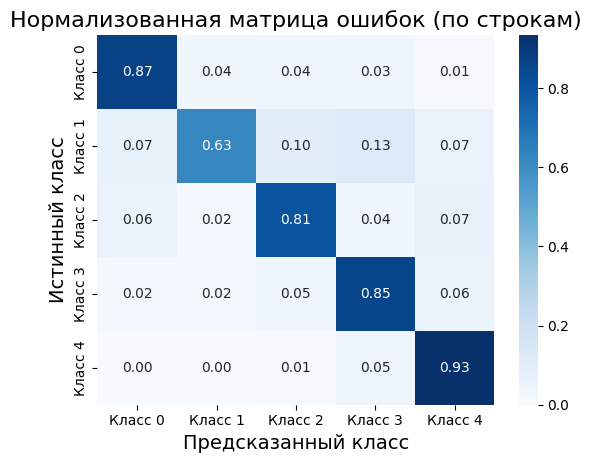

In [89]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Класс 0', 'Класс 1', 'Класс 2', 'Класс 3', 'Класс 4'],
            yticklabels=['Класс 0', 'Класс 1', 'Класс 2', 'Класс 3', 'Класс 4'])
plt.title('Нормализованная матрица ошибок (по строкам)', fontsize=16)
plt.xlabel('Предсказанный класс', fontsize=14)
plt.ylabel('Истинный класс', fontsize=14)
plt.show()

Из матрицы видно, что модель путает 1 класс со вторым и третьим, возможно, стоит поискать более явный признак, который поможет разделить классы более четко. 

## Подготовка артефактов модели для внедрения

In [ ]:
Итак, мы получили модель, сохраним весь пайплайн и проверим, загрузив, на тех же данных, что сохранение выполнено успешно.

In [90]:
# Добавляйте версию и дату в имя файла
model_name = f"age_category_prediction_V1_18022026.joblib"

# Сохраняйте метаданные вместе с моделью
metadata = {
    'model_version': '1.0',
    'training_date': '2026-02-18',
    'accuracy': 0.89
}

joblib.dump({
    'model': final_model, 
    'properties': columns_list,
    'metadata': metadata
}, model_name)

['age_category_prediction_V1_18022026.joblib']

In [91]:
loaded_data = joblib.load(model_name)
loaded_model = loaded_data['model']
columns_need = loaded_data['properties']

test_item = X_test
prediction = loaded_model.predict(test_item)
# Выведем 5-10 строк
n_to_show = min(10, len(prediction))
print(f"Показано {n_to_show} из {len(prediction)} предсказаний:\n")
print("-" * 40)

for i in range(n_to_show):
    if hasattr(prediction[i], 'round'):  # для числовых значений
        print(f"[{i:2d}] → {prediction[i]:.4f}")
    else:  # для категорий
        print(f"[{i:2d}] → {prediction[i]}")

print("-" * 40)
print(f"Форма предсказаний: {prediction.shape}")

Показано 10 из 1230 предсказаний:

----------------------------------------
[ 0] → 3.0000
[ 1] → 2.0000
[ 2] → 3.0000
[ 3] → 1.0000
[ 4] → 4.0000
[ 5] → 0.0000
[ 6] → 4.0000
[ 7] → 3.0000
[ 8] → 2.0000
[ 9] → 4.0000
----------------------------------------
Форма предсказаний: (1230,)


## Выводы о результатах работы

В ходе работы над проектом "Возраст по цифровому следу" были загружены и проанализированы данные из 6 датафреймов.
Данные были объединены в один датафрейм, а по итогам аггрегации и анализа логолв были созданы дополнительные признаки и добавлены в модель.
Был создан пайплайн предобработки данных, проведен отбор признаков и подбор гиперпараметров.

#### Характеристики базовой модели `DummyClassifier`.
Dummy
*Dummy*  
Дисбаланс классов:  
Класс 4 имеет наибольшую поддержку (376 объектов) — это доминирующий класс  
Класс 1 самый малочисленный (107 объектов) 

Recall Macro = 0.2 (идеально одинаковый на всех фолдах):  
Это явный признак стратегии "стратифицированный случайный выбор" или "равномерное предсказание"  
Модель "угадывает" каждый класс с вероятностью ~20% (вероятно, 5 классов → 1/5 = 0.2)  
Нулевая дисперсия (±0.0) подтверждает детерминированность стратегии  

Precision Macro = 0.0611:  
Очень низкое значение указывает на множество ложноположительных предсказаний 
Это логично: при случайном угадывании точность по каждому классу ≈ (доля класса)/(1/5)  

F1 Macro = 0.0937:  
Гармоническое среднее между низкой точностью и средней полнотой  
Служит базовым уровнем для сравнения  

#### Характеристики финальной модели.

Лучшая модель SVC:
Параметры: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__class_weight': 'balanced', 'onevsrestclassifier__estimator__gamma': 0.1, 'onevsrestclassifier__estimator__kernel': 'rbf'}
Лучший score (F1 Macro): 0.8118

Макро-усредненные метрики:
F1-score (macro): 0.8248
Precision (macro): 0.8355
Recall (macro): 0.8187


## Основные выводы 
Подбор гиперпараметров модели позволили улучшить качество модели по сравнению с базовой. Удаление части признаков не сделало модель лучше, но метрики не сильно упали, можно в дальнейшем поиграть другими признаками и посмотреть на метрики модели. (Возможно, уточненный набор признаков поможет более четко идентифицировать 1 класс)
Финальная модель теперь готова к использованию в продакшене, она довольно хорошо определяет возрастную категорию пользователя.
При необходимости можно выполнить поиск гиперпараметров с большим числом вариаций и попробовать взять другие признаки, чтобы еще улучшить модель.


